# Check new extended forcing RH-SH

In [3]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures

In [1]:
path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5'

In [129]:
df = pd.read_excel(path+'/DataML.xlsx', parse_dates=['time, UTC'])
# df.set_index('time, UTC', inplace=True)
df

,"time, UTC","ERA 5 pressure, kPa",Air Temp. °C,RH values,"Specific humidity, g kg-1"
0,2013-07-11 14:00:00,100.667453,6.819954,90.539907,5.559297
1,2013-07-11 15:00:00,100.639789,6.957644,88.377942,5.479365
2,2013-07-11 16:00:00,100.666109,8.925269,89.255245,6.329087
3,2013-07-11 17:00:00,100.663687,10.422386,88.422344,6.936189
4,2013-07-11 18:00:00,100.665562,8.218802,87.315260,5.900548
...,...,...,...,...,...
102548,2025-03-23 10:00:00,101.304578,NaN,NaN,NaN
102549,2025-03-23 11:00:00,101.356172,NaN,NaN,NaN
102550,2025-03-23 12:00:00,101.381453,NaN,NaN,NaN
102551,2025-03-23 13:00:00,101.438828,NaN,NaN,NaN


In [29]:
df['time, UTC']

0        2013-07-11 14:00:00
1        2013-07-11 15:00:00
2        2013-07-11 16:00:00
3        2013-07-11 17:00:00
4        2013-07-11 18:00:00
                 ...        
102548   2025-03-23 10:00:00
102549   2025-03-23 11:00:00
102550   2025-03-23 12:00:00
102551   2025-03-23 13:00:00
102552   2025-03-23 14:00:00
Name: time, UTC, Length: 102553, dtype: datetime64[ns]

In [130]:
def compute_es(T, method='Huang2018', water_only=False):
    """
        Compute the saturation vapor pressure [Pa] from the air temperature [°C].
        Use improved formulas for negative and positive temperatures.

        Parameters
        ----------
        T : float, pandas.core.series.Series
            Air temperature [°C].

        method : str, optional
            Method to compute the saturation vapor pressure. Default is 'Huang2018'. 
            Options are:

            - 'Huang2018': https://journals.ametsoc.org/view/journals/apme/57/6/jamc-d-17-0334.1.xml
            - 'Magnus'   : most commonly used simple formulas for the saturation vapor pressure

        water_only : bool, optional.  
            Activate or not the computation for water/ice separately. Default is False 
            (i.e., the computation is done for water and ice separately).

        Returns
        -------
        es : float, pandas.core.series.Series
            Saturation vapor pressure [Pa]
    """ 

    # Compute the saturation vapor pressure for the water and the ice
    if method == 'Huang2018':
        es_water = np.exp( 34.494 - 4924.99 / (T + 237.1) ) / (T + 105)**1.57
        es_ice = np.exp( 43.494 - 6545.8 / (T + 278) ) / (T + 868)**2

    elif method == 'Magnus':
        es_water = 610.94*np.exp( 17.625*T / (T + 243.04) )
        es_ice = 611.21*np.exp( 22.587*T / (T + 273.86) )

    else:
        raise ValueError('The method '+method+' is not supported. Options are: Huang2018 or Magnus.')

    # Merge them depending on the type
    if type(T) == pd.core.series.Series: 
        es_tot = es_water.where(T > 0, other=es_ice)
    elif isinstance(T, int) or isinstance(T, float):
        if T > 0: es_tot = es_water
        else: es_tot = es_ice
    else:
        raise TypeError('The type '+str(type(t))+' is not supported.')

    if water_only == False:
        return es_tot
    else:
        return es_water


def compute_e(T, RH, method='Huang2018', water_only=False):
    """
        Compute the vapor pressure [Pa] from the air temperature [°C] and relative humidity [%].
        See compute_es for more information.
    """ 
    return RH/100*compute_es(T, method=method, water_only=water_only)


def rho_humid_air(T, RH, P, method='Huang2018', water_only=False):
    """
        Compute the density of humid air [kg m$^{-3}$] from the air temperature [°C], relative humidity [%],
        and atmospheric pressure [Pa]. See compute_es for more information.
    """ 
    # Md = 28.965*1e-3 # Molecular molar mass of dry air [kg mol$^{-1}$]
    # Md = 28.9647*1e-3 # https://www.engineeringtoolbox.com/molecular-mass-air-d_679.html 
    Md = 28.965369*1e-3 #  https://doi.org/10.1080/10789669.2008.10391032 (2008)
    # Md = 28.9447*1e-3 # Molecular molar mass of dry air [kg mol$^{-1}$]
    Mv = 18.01528*1e-3 # Molecular molar mass of water [kg mol$^{-1}$]
    # R = 8.31446 # Molar gas constant [J K$^{-1}$ mol$^{-1}$]
    R = 8.314472 # https://doi.org/10.1080/10789669.2008.10391032 (2008)

    pv = compute_e(T, RH, method=method, water_only=water_only) # vapor pressure [Pa]
    pd = P - pv # dry air pressure [Pa]
    
    return (pd*Md + pv*Mv)/(R*(T+273.15))

def RH2AH(T, RH, method='Huang2018', water_only=False):
    '''
        Convert relative humidity [%] to absolute humidity [kg m^{-3}] from the air temperature [°C] 
        and relative humidity [%]. See compute_es for more information.

        Absolute humidity: mass of water in the unit volume
    '''
    e = compute_e(T, RH, method=method, water_only=water_only) # vapor pressure [Pa]
    # Mv = 18.0153*1e-3 # Molecular molar mass of water [kg mol$^{-1}$]
    Mv = 18.01528*1e-3 # Molecular molar mass of water [kg mol$^{-1}$]
    # R = 8.31446 # Molar gas constant [J K$^{-1}$ mol$^{-1}$]
    R = 8.314472 # https://doi.org/10.1080/10789669.2008.10391032 (2008)
    
    return e*Mv/(R*(T+273.15))

def RH2SH(T, RH, P, method='Huang2018', water_only=False):
    '''
        Convert relative humidity [%] to specific humidity [kg kg^{-1}] from the air temperature [°C],
        relative humidity [%], and atmospheric pressure [hPa]. See compute_es for more information.

        Relative humidity: mass of water in total mass of air

        Note: alternatively the specific humidity can be computed directly from the mass of vapor (mv)
        and dry air (md) as q = mv / (md + mv)
    '''
    a = RH2AH(T, RH, method=method, water_only=water_only) # absolute humidity [kg m^{-3}]
    rho = rho_humid_air(T, RH, P, method=method, water_only=water_only) # density of humid air [kg m$^{-3}$]
    
    return a/rho

In [33]:
df

,"time, UTC","ERA 5 pressure, kPa",Air Temp. °C,RH values,"Specific humidity, g kg-1"
0,2013-07-11 14:00:00,100.667453,6.819954,90.539907,5.559297
1,2013-07-11 15:00:00,100.639789,6.957644,88.377942,5.479365
2,2013-07-11 16:00:00,100.666109,8.925269,89.255245,6.329087
3,2013-07-11 17:00:00,100.663687,10.422386,88.422344,6.936189
4,2013-07-11 18:00:00,100.665562,8.218802,87.315260,5.900548
...,...,...,...,...,...
102548,2025-03-23 10:00:00,101.304578,NaN,NaN,NaN
102549,2025-03-23 11:00:00,101.356172,NaN,NaN,NaN
102550,2025-03-23 12:00:00,101.381453,NaN,NaN,NaN
102551,2025-03-23 13:00:00,101.438828,NaN,NaN,NaN


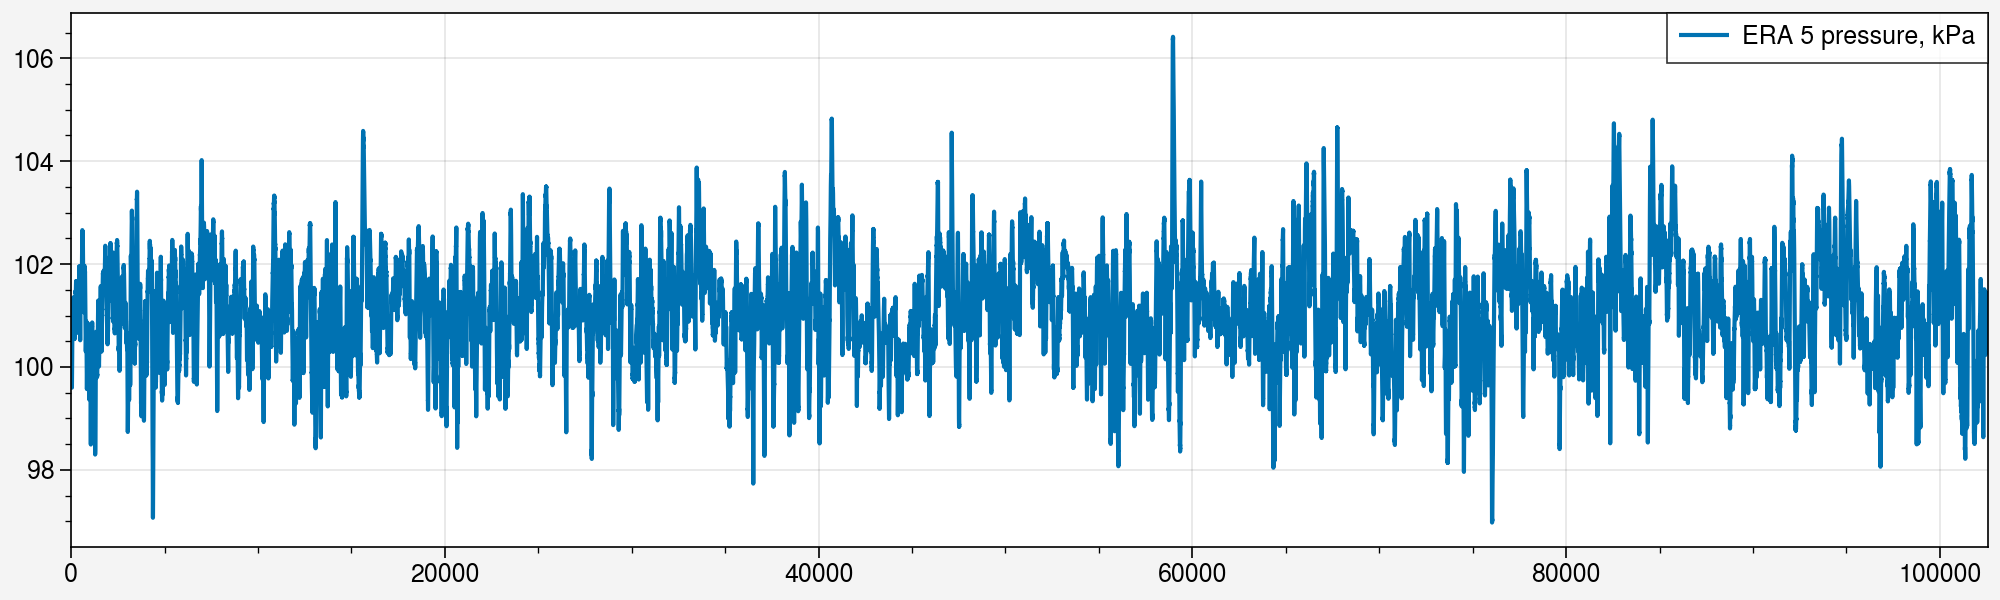

In [44]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,3))

df['ERA 5 pressure, kPa'].plot(ax=axs[0])
axs.legend()

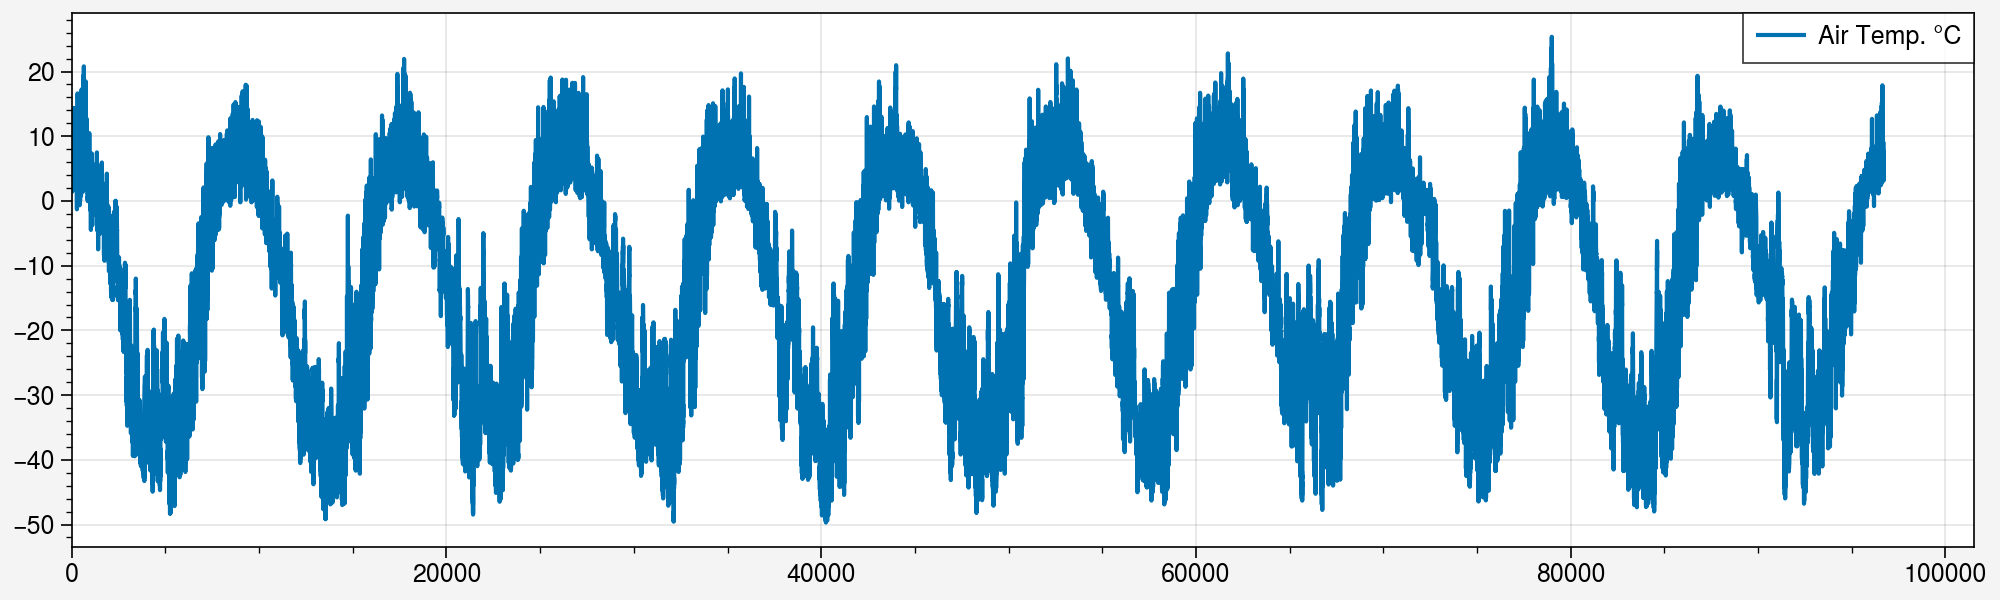

In [45]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,3))

df['Air Temp. °C'].plot(ax=axs[0])
axs.legend()

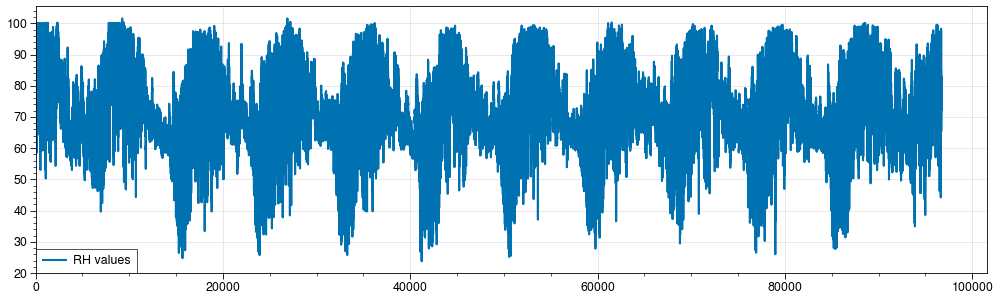

In [77]:
%matplotlib widget
fig, axs = pplt.subplots(figsize=(10,3))

df['RH values'].plot(ax=axs[0])
axs.legend()

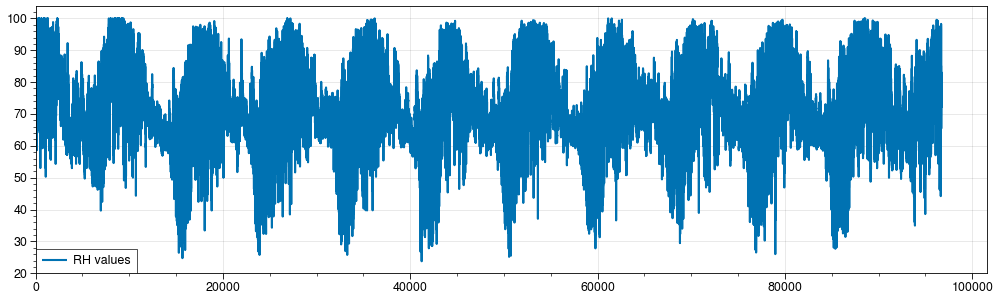

In [80]:
%matplotlib widget
fig, axs = pplt.subplots(figsize=(10,3))

df['RH values'].clip(upper=100).plot(ax=axs[0])
axs.legend()

In [49]:
df.columns

Index(['time, UTC', 'ERA 5 pressure, kPa', 'Air Temp. °C', 'RH values',
       'Specific humidity,  g kg-1'],
      dtype='object')

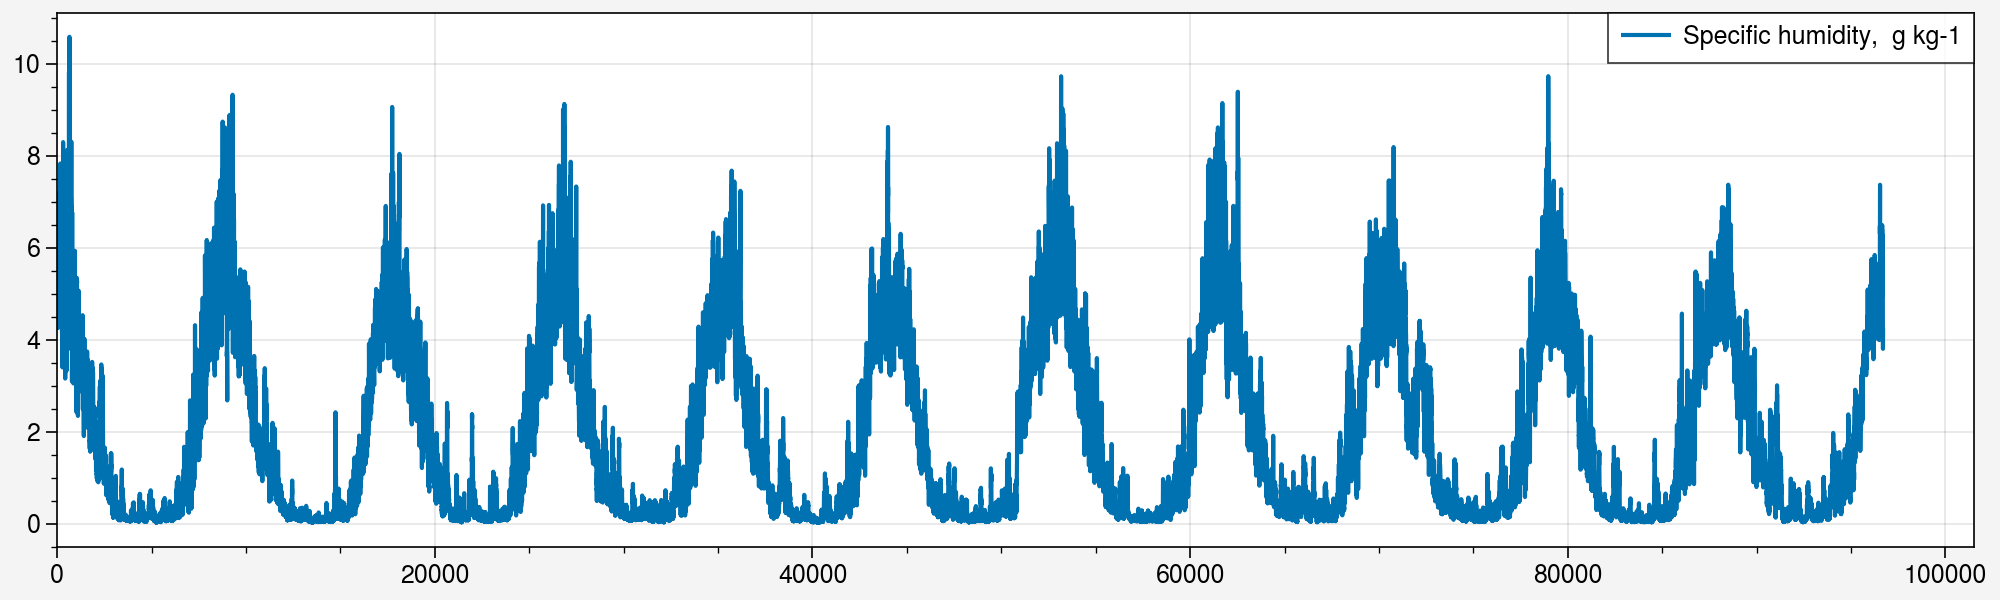

In [101]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,3))

df['Specific humidity,  g kg-1'].plot(ax=axs[0])
axs.legend()

In [78]:
df['RH values']

0         90.539907
1         88.377942
2         89.255245
3         88.422344
4         87.315260
            ...    
102548          NaN
102549          NaN
102550          NaN
102551          NaN
102552          NaN
Name: RH values, Length: 102553, dtype: float64

In [79]:
df['RH values'].clip(upper=100)

0         90.539907
1         88.377942
2         89.255245
3         88.422344
4         87.315260
            ...    
102548          NaN
102549          NaN
102550          NaN
102551          NaN
102552          NaN
Name: RH values, Length: 102553, dtype: float64

In [102]:
# Already done

# # On suppose que tu as une colonne 'Temperature' pour le T dans la formule
# T = df['Air Temp. °C']
# RH = df['RH values']
# time = df['time, UTC']

# # Créer des masques pour les périodes
# mask_2013_2014 = (time >= '2013-01-01') & (time < '2014-01-01')
# mask_2014_2023 = (time >= '2014-01-01') & (time < '2023-01-01')
# mask_2023_2025 = (time >= '2023-01-01') & (time < '2025-01-01')

# # Créer une nouvelle colonne pour les RH corrigés
# df['RH corrected'] = RH  # Valeur par défaut = RH mesurée

# # Appliquer les formules selon les périodes
# df.loc[mask_2013_2014, 'RH corrected'] = RH[mask_2013_2014] * (-0.00025 * T[mask_2013_2014] + 0.85) + 15
# df.loc[mask_2014_2023, 'RH corrected'] = RH[mask_2014_2023] * (0.0017 * T[mask_2014_2023] + 1.03)
# # de 2023 à 2025 : RH corrigée = RH mesurée (déjà le cas)

# # (Optionnel) Si tu veux t'assurer que RH corrected ne dépasse pas 100
# df['RH corrected'] = df['RH corrected'].clip(upper=100)


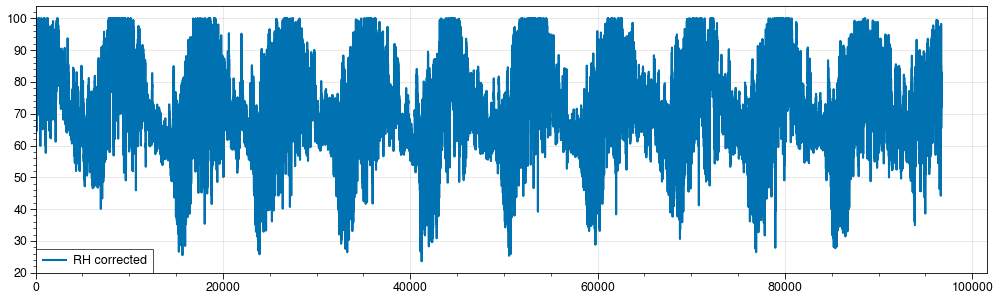

In [103]:
%matplotlib widget
fig, axs = pplt.subplots(figsize=(10,3))

df['RH corrected'].plot(ax=axs[0])
axs.legend()

In [131]:
%matplotlib widget

# ds['RH [%] (Humidity-Temperature probe, R...)'].plot(figsize=(8,4))
# df['TTT [°C] (Humidity-Temperature probe, R...)'].plot()
# df['PPPP [hPa] (ERA5 reanalyses)'].plot()

Qair = RH2SH(
    df['Air Temp. °C'], # °C
    # df['RH values'].clip(upper=100), # %
    df['RH values'], # %
    # df['RH corrected'], # %
    df['ERA 5 pressure, kPa']*1e3, # Pa 
    method='Huang2018', water_only=False)*1e3 # g/kg

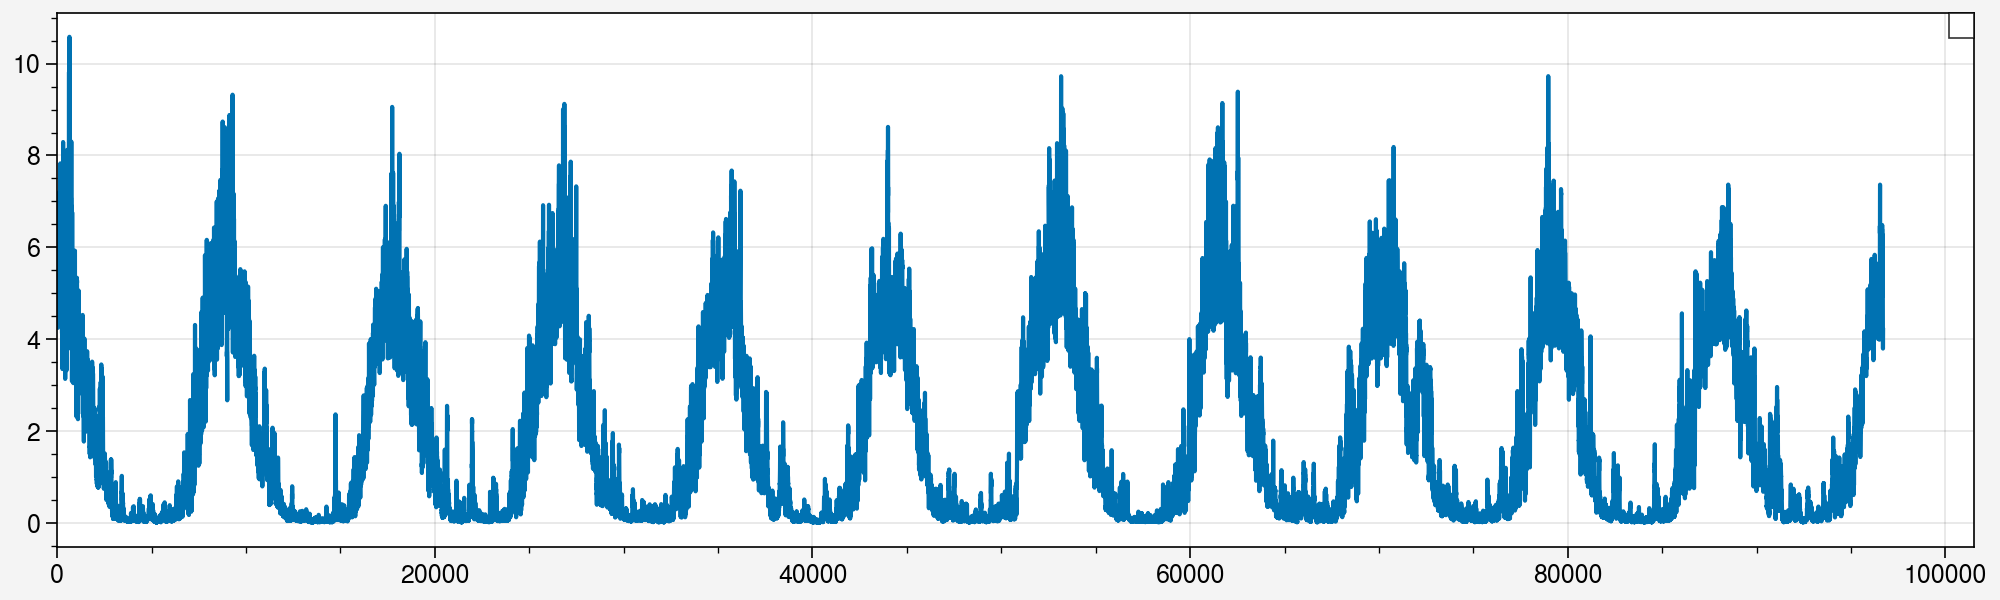

In [132]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,3))

Qair.plot(ax=axs[0])
axs.legend()

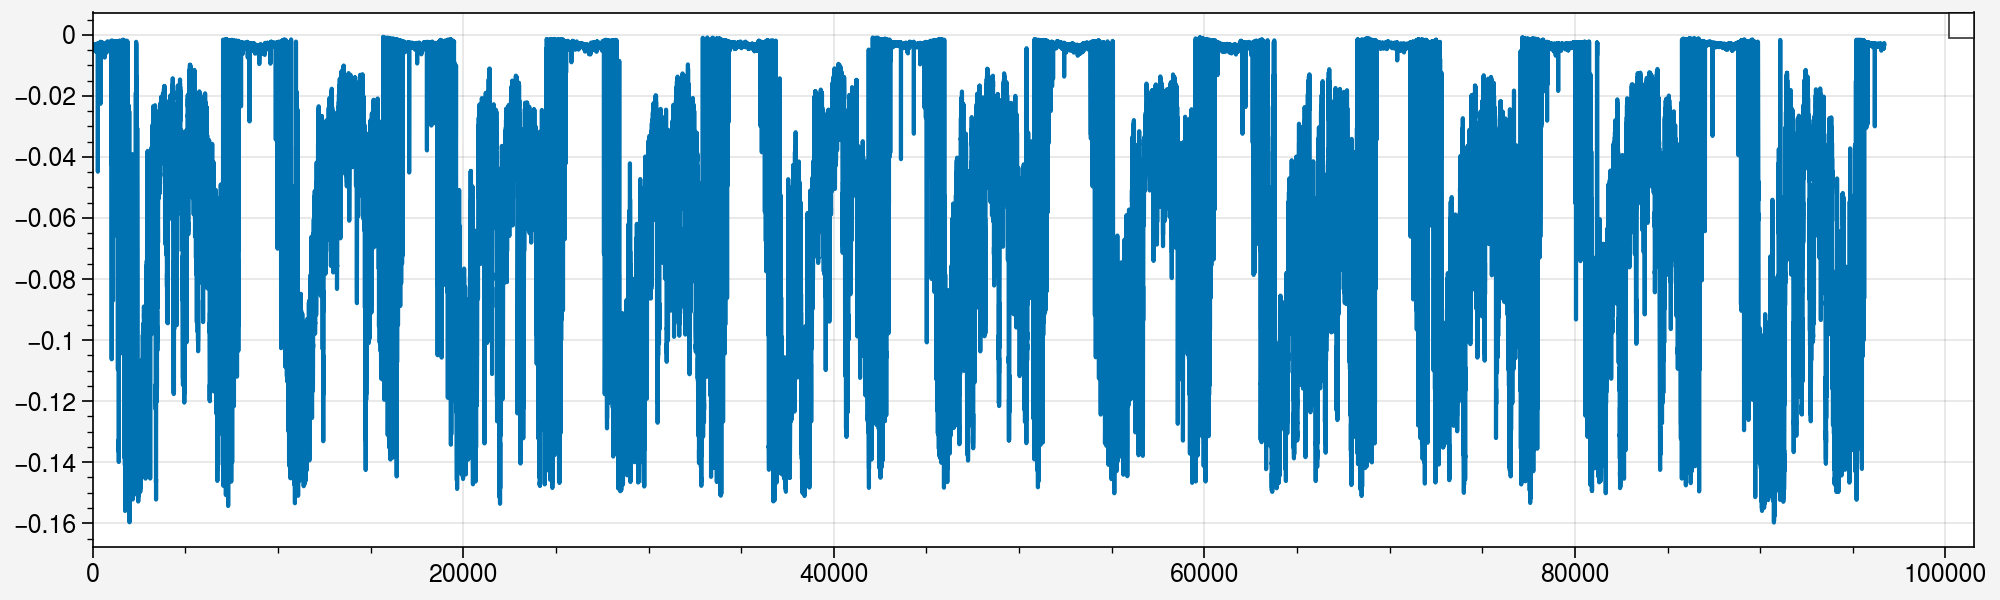

In [133]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,3))

(Qair-df['Specific humidity,  g kg-1']).plot(ax=axs[0])
axs.legend()

In [134]:
df

,"time, UTC","ERA 5 pressure, kPa",Air Temp. °C,RH values,"Specific humidity, g kg-1"
0,2013-07-11 14:00:00,100.667453,6.819954,90.539907,5.559297
1,2013-07-11 15:00:00,100.639789,6.957644,88.377942,5.479365
2,2013-07-11 16:00:00,100.666109,8.925269,89.255245,6.329087
3,2013-07-11 17:00:00,100.663687,10.422386,88.422344,6.936189
4,2013-07-11 18:00:00,100.665562,8.218802,87.315260,5.900548
...,...,...,...,...,...
102548,2025-03-23 10:00:00,101.304578,NaN,NaN,NaN
102549,2025-03-23 11:00:00,101.356172,NaN,NaN,NaN
102550,2025-03-23 12:00:00,101.381453,NaN,NaN,NaN
102551,2025-03-23 13:00:00,101.438828,NaN,NaN,NaN


In [135]:
df.columns

Index(['time, UTC', 'ERA 5 pressure, kPa', 'Air Temp. °C', 'RH values',
       'Specific humidity,  g kg-1'],
      dtype='object')

In [136]:
df['Specific humidity new,  g kg-1'] = Qair
df

,"time, UTC","ERA 5 pressure, kPa",Air Temp. °C,RH values,"Specific humidity, g kg-1","Specific humidity new, g kg-1"
0,2013-07-11 14:00:00,100.667453,6.819954,90.539907,5.559297,5.555353
1,2013-07-11 15:00:00,100.639789,6.957644,88.377942,5.479365,5.475476
2,2013-07-11 16:00:00,100.666109,8.925269,89.255245,6.329087,6.324599
3,2013-07-11 17:00:00,100.663687,10.422386,88.422344,6.936189,6.931274
4,2013-07-11 18:00:00,100.665562,8.218802,87.315260,5.900548,5.896362
...,...,...,...,...,...,...
102548,2025-03-23 10:00:00,101.304578,NaN,NaN,NaN,NaN
102549,2025-03-23 11:00:00,101.356172,NaN,NaN,NaN,NaN
102550,2025-03-23 12:00:00,101.381453,NaN,NaN,NaN,NaN
102551,2025-03-23 13:00:00,101.438828,NaN,NaN,NaN,NaN


In [137]:
path

'/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5'

In [140]:
df.set_index('time, UTC', inplace=True)
df

,"ERA 5 pressure, kPa",Air Temp. °C,RH values,"Specific humidity, g kg-1","Specific humidity new, g kg-1"
"time, UTC",,,,,
2013-07-11 14:00:00,100.667453,6.819954,90.539907,5.559297,5.555353
2013-07-11 15:00:00,100.639789,6.957644,88.377942,5.479365,5.475476
2013-07-11 16:00:00,100.666109,8.925269,89.255245,6.329087,6.324599
2013-07-11 17:00:00,100.663687,10.422386,88.422344,6.936189,6.931274
2013-07-11 18:00:00,100.665562,8.218802,87.315260,5.900548,5.896362
...,...,...,...,...,...
2025-03-23 10:00:00,101.304578,NaN,NaN,NaN,NaN
2025-03-23 11:00:00,101.356172,NaN,NaN,NaN,NaN
2025-03-23 12:00:00,101.381453,NaN,NaN,NaN,NaN


In [141]:
df.to_excel(path+'/DataML_new.xlsx')

In [142]:
df.to_csv(path+'/DataML_new.csv')